In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
import os

print(tf.__version__)
print(keras.__version__)

2.3.0
2.4.0


# 데이터셋 만들기

In [17]:
image_datas = glob('Train/*/*.jpg')
class_name = [forder for forder in forders if not '.' in forder]
dic = {"Normal" : 0,
       "Hollenhorst_Emboli" : 1,
      "Branch_Retinal_Artery_Occlusion" : 2,
      "Cilio-Retinal_Artery_Occlusion" : 3,
      "Branch_Retinal_Vein_Occlusion" : 4,
      "Central_Retinal_Vein_Occlusion" : 5,
      "Hemi-Central_Retinal_Vein_Occlusion" : 6,
      "Background_Diabetic_Retinopathy" : 7,
      "Proliferative_Diabetic_Retinopathy":8,
      "Arteriosclerotic_Retinopathy":9,
      "Hypertensive_Retinopathy":10,
      "Coats":11,
      "Macroaneurism" :12,
      "Choroidal_Neovascularization":13,
      "diabetic_retinopathy":15,
      "glaucomatous":16,
      "cataract":17,
      "retina_disease":18,
      "Diabetic_Macular_Edema":19}

In [22]:
X = []
Y = []
for imagename in image_datas:
    image = Image.open(imagename)
    image = image.resize((128,128))
    image = np.array(image)
    X.append(image)
    label = imagename.split('\\')[1]
    label = dic[label]
    Y.append(label)

In [23]:
X = np.array(X)
Y = np.array(Y)

# 데이터셋 분리

In [24]:
train_images, test_images, train_labels, test_labels = train_test_split(X,Y, test_size = 0.2, shuffle=True, random_state=44)

train_labels = train_labels[..., tf.newaxis]
test_labels = test_labels [..., tf.newaxis]
# tf.newaxis : 새로운 차원을 추가하여, 다른 모양의 배열간 브로드 캐스팅을 가능하게 함

train_images.shape, train_labels.shape, test_images.shape, test_labels.shape

((2904, 128, 128, 3), (2904, 1), (726, 128, 128, 3), (726, 1))

In [26]:
## train set의 각 class별 image 수 확인
unique, counts = np.unique(np.reshape(train_labels, (2904)), axis =-1, return_counts=True)
dict(zip(unique, counts))

{0: 1350,
 1: 11,
 2: 7,
 3: 8,
 4: 10,
 5: 15,
 6: 9,
 7: 57,
 8: 17,
 9: 32,
 10: 29,
 11: 14,
 12: 6,
 13: 53,
 15: 603,
 16: 404,
 17: 75,
 18: 82,
 19: 122}

In [29]:
## test set의 각 class별 image수 확인
unique, counts = np.unique(np.reshape(test_labels, (726)), axis =-1, return_counts=True)
dict(zip(unique, counts))

{0: 352,
 1: 2,
 3: 1,
 4: 1,
 5: 10,
 6: 3,
 7: 14,
 8: 6,
 9: 1,
 10: 7,
 12: 2,
 13: 8,
 15: 139,
 16: 108,
 17: 25,
 18: 18,
 19: 29}

In [31]:
N_TRAIN = train_images.shape[0]
N_TEST = test_images.shape[0]

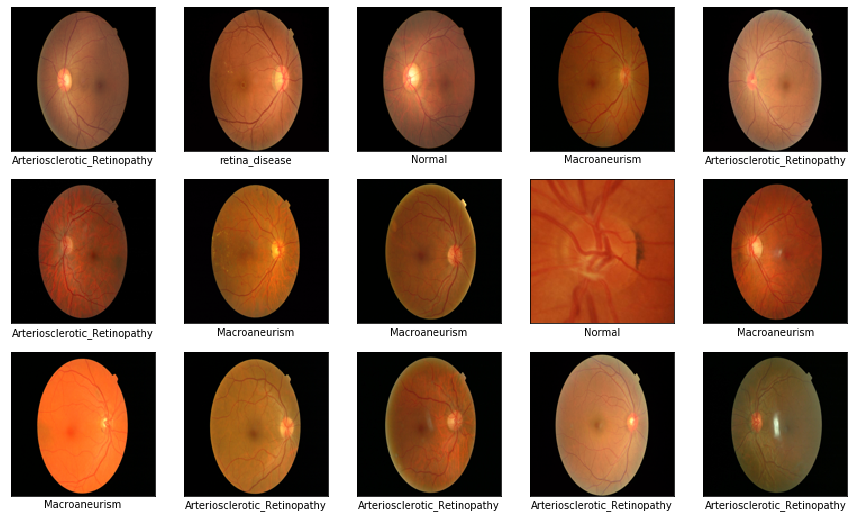

In [33]:
## Data확인
plt.figure(figsize = (15,9))
for i in range(15):
    img_idx = np.random.randint(0, N_TRAIN)
    plt.subplot(3,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[img_idx])
    plt.xlabel(class_name[train_labels[img_idx][0]])

In [35]:
## pixel값을 0~1 범위로 조정
train_images = train_images.astype(np.float32) / 255.
test_images = test_images.astype(np.float32) / 255.

# label을 onehot-encoding
train_labels = keras.utils.to_categorical(train_labels)
test_labels = keras.utils.to_categorical(test_labels)

In [38]:
print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)

(2904, 128, 128, 3) (2904, 20)
(726, 128, 128, 3) (726, 20)


In [53]:
## Hyper parameters
learning_rate = 0.01
EPOCHS = 10
BATCH = 50
CLASS = 20

In [54]:
## dataset 구성
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).shuffle(
buffer_size = 2904).batch(BATCH).repeat()

In [55]:
test_dataset = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(BATCH)

#  모델 구성


In [58]:
def cnn_model():
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(filters = 32, kernel_size = 3,
                                 activation = 'relu', padding = 'same',
                                 input_shape = (128,128,3)))
    model.add(keras.layers.MaxPool2D(padding = 'same'))
    model.add(keras.layers.Conv2D(filters = 64, kernel_size = 3,
                                 activation = 'relu', padding = 'same'))
    model.add(keras.layers.MaxPool2D(padding='same'))
    model.add(keras.layers.Conv2D(filters = 128, kernel_size = 3,
                                 activation = 'relu', padding = 'same'))
    model.add(keras.layers.MaxPool2D(padding='same'))
    
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(256, activation='relu'))
    model.add(keras.layers.Dropout(0.4))
    model.add(keras.layers.Dense(20, activation='softmax'))
    return model

In [59]:
## 모델 생성. compile and summary
model = cnn_model()
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate),
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 64, 64, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 16, 16, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 32768)            

In [60]:
## parameters for training
steps_per_epoch = N_TRAIN//BATCH
validation_steps = N_TEST//BATCH
print(steps_per_epoch, validation_steps)

58 14


In [85]:
# 텐서보드 사용
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

model = cnn_model()


In [61]:
## Training
history = model.fit(train_dataset, epochs = EPOCHS, steps_per_epoch = steps_per_epoch, validation_data = test_dataset, validation_steps = validation_steps)

Epoch 1/10
58/58 [==============================] - 39s 666ms/step - loss: 5.2683 - accuracy: 0.4400 - val_loss: 1.3785 - val_accuracy: 0.4929
Epoch 2/10
58/58 [==============================] - 41s 712ms/step - loss: 1.3429 - accuracy: 0.4832 - val_loss: 1.1894 - val_accuracy: 0.5314
Epoch 3/10
58/58 [==============================] - 38s 663ms/step - loss: 1.2187 - accuracy: 0.4989 - val_loss: 1.1381 - val_accuracy: 0.5614
Epoch 4/10
58/58 [==============================] - 40s 685ms/step - loss: 1.1721 - accuracy: 0.5259 - val_loss: 1.0710 - val_accuracy: 0.5814
Epoch 5/10
58/58 [==============================] - 41s 704ms/step - loss: 1.1449 - accuracy: 0.5371 - val_loss: 1.0506 - val_accuracy: 0.5957
Epoch 6/10
58/58 [==============================] - 42s 724ms/step - loss: 1.0925 - accuracy: 0.5420 - val_loss: 1.0626 - val_accuracy: 0.5986
Epoch 7/10
58/58 [==============================] - 41s 710ms/step - loss: 1.0965 - accuracy: 0.5406 - val_loss: 1.0318 - val_accuracy: 0.5871

In [62]:
model.evaluate(test_dataset)

15/15 [==============================] - 2s 151ms/step - loss: 1.0029 - accuracy: 0.5730


[1.0029047727584839, 0.5730027556419373]

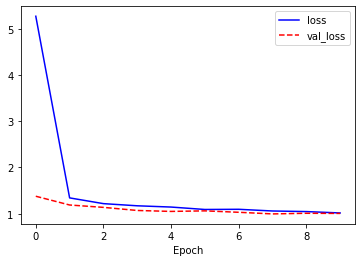

In [63]:
## Plot losses
plt.plot(history.history['loss'], 'b-',label = 'loss')
plt.plot(history.history['val_loss'],'r--', label = 'val_loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

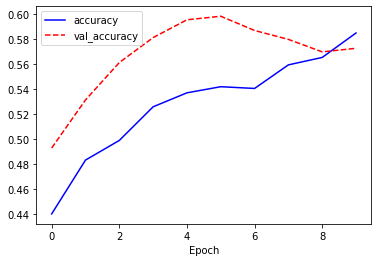

In [64]:
## Plot accuracy
plt.plot(history.history['accuracy'], 'b-', label='accuracy')
plt.plot(history.history['val_accuracy'], 'r--', label = 'val_accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [72]:
## 결과 확인
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img)
    
    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'
    
    plt.xlabel("{} {:2.0f}% ({})".format(class_name[predicted_label],
                                        100*np.max(predictions_array),
                                        class_name[true_label]),
                                        color = color)
    
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    #plt.xticks([])
    plt.xticks(range(CLASS), class_name, rotation=90)
    plt.yticks([])
    
    thisplot = plt.bar(range(CLASS), predictions_array, color='#777777')
    
    plt.ylim([0,1])

    predicted_label = np.argmax(predictions_array)
    
    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

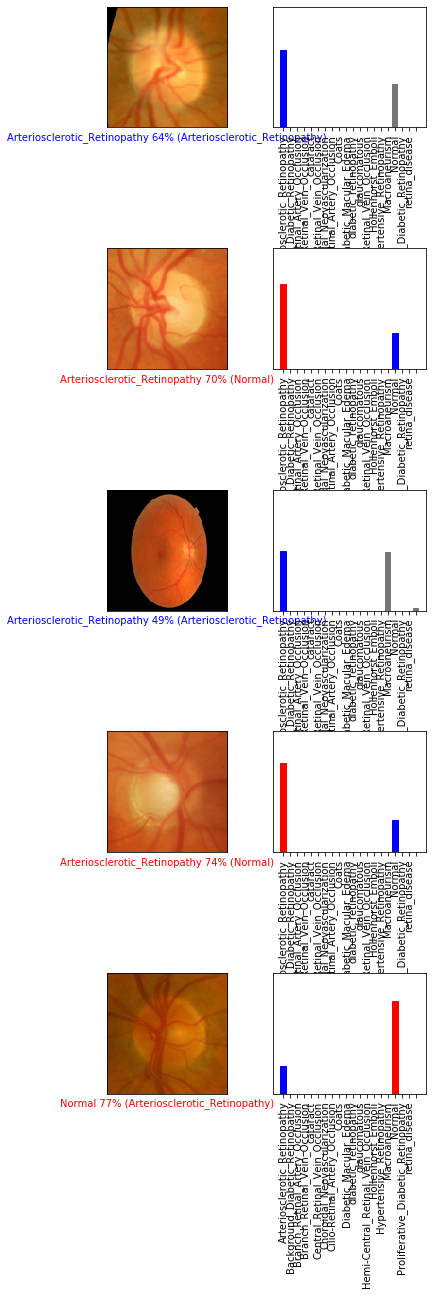

In [82]:
rnd_idx = np.random.randint(1, N_TEST//BATCH)
img_cnt = 0
for images, labels in test_dataset:
    img_cnt +=1
    if img_cnt != rnd_idx:
        continue
    predictions = model(images, training=False)
    num_rows = 5
    num_cols = 1
    num_images = num_rows*num_cols
    
    labels = tf.argmax(labels, axis=-1)
    
    plt.figure(figsize = (3*2*num_cols, 4*num_rows))
    plt.subplots_adjust(hspace=1.0)
    
    for i in range(num_images):
        plt.subplot(num_rows, 2*num_cols, 2*i+1)
        plot_image(i, predictions.numpy(), labels.numpy(), images.numpy())
        plt.subplot(num_rows, 2*num_cols, 2*i+2)
        plot_value_array(i,predictions.numpy(), labels.numpy())
        
    break